# HW3

Submitted by: Lior Sukman (ID 319124244) Efrat Kohen (ID 300385564) Mandy Rosemblaum (ID 305747230)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

## Q1

a) Load the time series file "changepoint_ts.csv"

In [2]:
#Build Dataframe
CSV_URL = "https://raw.githubusercontent.com/ZviBaratz/ml_for_neuro/master/changepoint_ts.csv"
df = pd.read_csv(CSV_URL, usecols=["x"])
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       506 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


b) Create the matrix L and calculate L^(-1)

In [3]:
data_points = df.shape[0]

L = np.identity(data_points)
for i in range(1, data_points):
   L[i, i - 1] = -1

L_inv = np.linalg.inv(L)

c) Solve the Lasso model and transform the result using the relation beta = L_inv * u. Find
the best lambda using cross-validation.

In [4]:
alphas = np.logspace(-4, 2, 28)
parameters = {'alpha': alphas}

labels = df['x'].copy()

model = linear_model.Lasso(max_iter = 10_000)
clf = GridSearchCV(model, parameters, cv = 5)
clf.fit(L_inv, labels)

print('best parameter is:') 
print(clf.best_params_)

best parameter is:
{'alpha': 0.000774263682681127}


In [5]:
model = clf.best_estimator_

betta = np.dot(L_inv, model.coef_) + model.intercept_

d) Plot the fitted model as in the figure above.

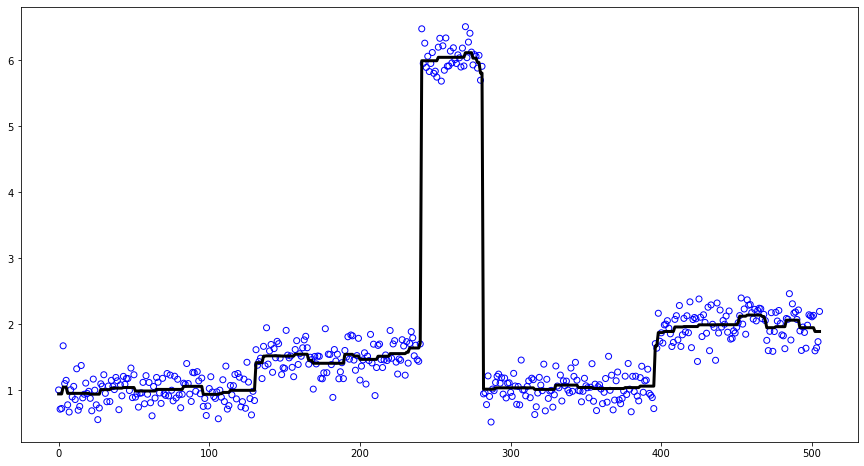

In [6]:
plt.figure(figsize=(15,8))
plt.scatter(np.arange(data_points), labels, facecolors='none', edgecolors='b')
plt.plot(betta, color = 'k', linewidth = 3)
plt.show()

## Q2

In [7]:
#Build Dataframe with the requierd features
csv_url = 'https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/tutorials/data/chicagoCrimes10k.csv'
df=pd.read_csv(csv_url)
data = df[["Arrest", "Date", "Year", "Primary Type", "Location Description", "Domestic", "Beat", "District", "Ward", "Community Area", "FBI Code"]]

(c) Transform the date to day in week, hour in day, month in year

In [8]:
data.insert(1, 'Date_object', pd.to_datetime(data['Date'], format='%m/%d/%Y %I:%M:%S %p'))
data.insert(1, 'Hour', pd.DatetimeIndex(data['Date_object']).hour)
data.insert(2, 'Week_day', data['Date_object'].dt.dayofweek)
data.insert(3, 'Month', pd.DatetimeIndex(data['Date_object']).month)
data = data.drop(columns=['Date', 'Date_object'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Arrest                9999 non-null   bool   
 1   Hour                  9999 non-null   int64  
 2   Week_day              9999 non-null   int64  
 3   Month                 9999 non-null   int64  
 4   Year                  9999 non-null   int64  
 5   Primary Type          9999 non-null   object 
 6   Location Description  9993 non-null   object 
 7   Domestic              9999 non-null   bool   
 8   Beat                  9999 non-null   int64  
 9   District              9837 non-null   float64
 10  Ward                  9999 non-null   int64  
 11  Community Area        9999 non-null   int64  
 12  FBI Code              9999 non-null   object 
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 878.9+ KB


(b) Transform the categorical variables to binary variables ("one-hot encoding").

In [10]:
#Build Dataframes of binary variables and join with data 
categorical_variables = ['Hour', 'Week_day', 'Month', 'Year', 'Primary Type', 'Location Description', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',  'FBI Code'] 
df_list = []
for categoria in categorical_variables:
    df = pd.get_dummies(data[categoria], prefix=categoria)#, drop_first=True)
    data = pd.concat([data, df] ,axis=1)
    data = data.drop(columns=[categoria])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 603 entries, Arrest to FBI Code_26
dtypes: bool(1), uint8(602)
memory usage: 5.8 MB


(a) Split to training set and test set (80%-20%)

In [11]:
def split_df (target_name: str, data: pd.DataFrame):
    """ 
    Split df into random train and test subsets based on target name column

    Parameters
    ----------
    target_name : str
        target column name
    data : DataFrame
        DataFrame  

    return
    ----------
    X_train, X_test, y_train, y_test
    """
    X = data.drop(columns=[target_name])
    y = data[target_name].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [12]:
target_name = "Arrest"
X_train, X_test, y_train, y_test = split_df(target_name, data)

(d) Train a Random Forest model (tune the parameter "max_features" using Out of Bag error)

In [14]:
num_features = X_train.shape[1]
max_features_options = np.arange(1, np.sqrt(num_features))

best_score = 0
best_param = None
best_model = None

for max_features in max_features_options:
    print(max_features)
    random_forest = RandomForestClassifier(random_state = 0, oob_score = True, max_features = int(max_features)) 
    random_forest.fit(X_train, y_train)
    score = random_forest.oob_score_
    if score > best_score:
        best_score = score
        best_param = max_features
        best_model = random_forest
        
y_predicted = best_model.predict(X_test)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


(e) Plot the variable importance

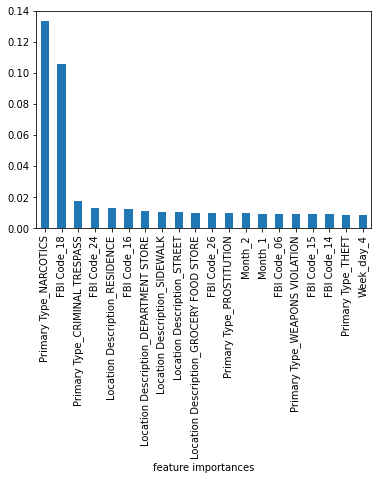

In [15]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
_=feat_importances.nlargest(20).plot(kind='bar')
_=plt.xlabel("feature importances")

(f) Calculate the AUC on the test set.

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
print(f"The AUC is {auc(fpr, tpr)}")

The AUC is 0.8159543818126439
